# Soft Actor-Critic
### Implementation using Equinox

In [5]:
import equinox as eqx
import jax.numpy as jnp
import jax.random as jrandom

import jax
from jax.lax import stop_gradient
from jax import jit, grad, vmap
import optax

from src.systems.linear import StochasticDoubleIntegrator
from src.utilities.utilities import Tracker

import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
class SimpleNetwork(eqx.Module):
    layers: list
    bias: jnp.ndarray

    def __init__(self, dim, key):
        in_size, hidden_size, out_size = dim
        key1, key2, key3 = jrandom.split(key, 3)
        self.layers = [eqx.nn.Linear(in_size, hidden_size, key=key1),
                        jax.nn.tanh,
                        eqx.nn.Linear(hidden_size, hidden_size, key=key2),
                        jax.nn.tanh,
                        eqx.nn.Linear(hidden_size, out_size, key=key3)]
        self.bias = jnp.ones(out_size)
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x + self.bias

In [22]:
class SoftActorCritic:
    def __init__(self, dim_q, dim_v, dim_pi, key):
        key_q, key_v, key_pi = jrandom.split(key, 3)
        self.SQF = SoftQFunction(dim_q, key_q)
        self.SVF = SoftValueFunction(dim_v, key_v)
        self.PI = SoftPolicyFunction(dim_pi, key_pi)
        self.buffer = list()
        self.tracker = Tracker(['state0', 'state1', 'control', 'cost', 'V_value', 'V_loss', 
                                    'Q_value', 'Q_loss', 'policy_angle', 'policy_force'])
    
    def update(self, s0, u, tracking=True):
        v_value = self.SVF.predict(s0, output_value=True)
        q_value = self.SQF.predict(s0, u, output_value=True)
        
        v_loss = self.SVF.take_step(self.buffer, self.SQF.predict, self.PI.log_prob)
        q_loss = self.SQF.take_step(self.buffer, self.SVF.predict)
        #self.PI.update(s0, u, self.SQF.predict)

        if tracking:
            control_angle = jnp.arctan2(self.PI.params[0,0], self.PI.params[0,1])
            control_force = jnp.linalg.norm(self.PI.params)
            self.tracker.add([s0[0], s0[1], u, None, v_value, v_loss, q_value, q_loss,
                                    control_angle, control_force])
    
    def get_control(self, state):
        return self.PI.get_control(state)
    
    def add_to_buffer(self, transition):
        self.buffer.append(transition)


class SoftQFunction:
    def __init__(self, dimension, key, eta=1e-3):
        self.model = SimpleNetwork(dimension, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
        self.gamma = .9
        self.sample_size = 1
    
    @eqx.filter_jit
    @eqx.filter_value_and_grad
    def loss_fn(self, D, value_func):
        bellman_residual = 0
        N = len(D)
        for it in range(min(N, self.sample_size)):
            if it == 0:
                s0, u, rew, s1 = D[-1]
            else:
                idx = np.random.randint(0, N)
                s0, u, rew, s1 = D[idx]
            Q = self.predict(s0, u)
            Q_hat = rew + self.gamma * value_func(s1)
            bellman_residual += (Q - Q_hat)**2 / 2
        return jnp.mean(bellman_residual / min(N, self.sample_size))
    
    def take_step(self, D, value_func):
        loss, grads = self.loss_fn(D, value_func)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)
        return loss
    
    def predict(self, state, control, output_value=False):
        input = jnp.hstack([state, control])
        y_hat = self.model(input)
        if output_value:
            return jnp.mean(y_hat)
        else:
            return y_hat


class SoftValueFunction:
    def __init__(self, dimension, key, eta=1e-3):
        self.model = SimpleNetwork(dimension, key)
        self.optimizer = optax.sgd(eta)
        self.opt_state = self.optimizer.init(self.model)
        self.sample_size = 1
    
    @eqx.filter_jit
    @eqx.filter_value_and_grad
    def loss_fn(self, D, q_func, pi_log_func):
        squared_residual_error = 0
        N = len(D)
        for it in range(min(N, self.sample_size)):
            if it == 0:
                s0, u, _, _ = D[-1]
            else:
                idx = np.random.randint(0, N)
                s0, u, _, _ = D[idx]
            V = self.predict(s0)
            # Sample u from policy pi
            Q = q_func(s0, u)
            log_pi = pi_log_func(s0, u)
            squared_residual_error += (V - (Q - log_pi))**2 / 2
        return jnp.mean(squared_residual_error / min(N, self.sample_size))

    def take_step(self, D, q_func, pi_log_func):
        loss, grads = self.loss_fn(D, q_func, pi_log_func)
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.model = eqx.apply_updates(self.model, updates)
        return loss
    
    def predict(self, state, output_value=False):
        if output_value:
            return jnp.mean(self.model(state))
        else:
            return self.model(state)

class SoftPolicyFunction:
    def __init__(self, dim, key):
        self.params = jrandom.normal(key, dim).T
        self.stdev = .5
        self.eta = 1e-2
    
    def predict(self, state):
        return jnp.dot(self.params, state)
    
    def get_control(self, state):
        u_star = self.predict(state)
        xi = np.random.normal()
        u = u_star + xi * self.stdev
        return u, u_star
    
    def grad_phi(self, state, control, q_func):
        params = self.params
        grad_phi_log_pi = jax.grad(self.log_pi)(params, state, control)
        grad_u_log_pi = jax.grad(self.log_pi, argnums=2)(params, state, control)
        grad_Q = jax.grad(q_func, argnums=1)(state, control, output_value=True)
        return grad_phi_log_pi + (grad_u_log_pi - grad_Q)*state
    
    def update(self, state, control, q_func):
        grads = self.grad_phi(state, control, q_func)
        self.params += self.eta * grads

    def log_pi(self, params, state, control):
        mu = jnp.dot(stop_gradient(params), state)
        prob = -.5 * ((stop_gradient(control) - mu) / self.stdev)**2 - jnp.log(self.stdev) + jnp.log(2*jnp.pi)/2
        return prob[0]

    def log_prob(self, state, control):
        mu = self.predict(state)
        return -.5 * ((control - mu) / self.stdev)**2 - jnp.log(self.stdev) + jnp.log(2*jnp.pi)/2




In [25]:
seed = 0
T = 10

key = jrandom.PRNGKey(seed)

x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)

dim_q = (3, 32, 1)
dim_v = (2, 32, 1)
dim_pi = (2, 1)

SAC = SoftActorCritic(dim_q, dim_v, dim_pi, key)
key0, key1, key2, key = jrandom.split(key, 4)

time_horizon = jnp.arange(0, T, SDI.dt)
for t in time_horizon:
    s0_estimate = SDI.observe(key0)
    u, _ = SAC.get_control(s0_estimate)
    _, cost, done = SDI.update(key1, u, info=True)
    s1_estimate = SDI.observe(key2)

    SAC.add_to_buffer((s0_estimate, u, -cost, s1_estimate))
    SAC.update(s0_estimate, u)

    # step
    key0, key1, key2, key = jrandom.split(key, 4)

    if done:
        x0 = jrandom.normal(key, (2,))*2
        SDI.reset(x0)



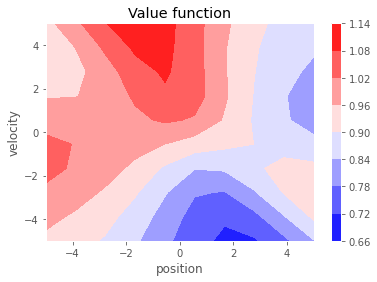

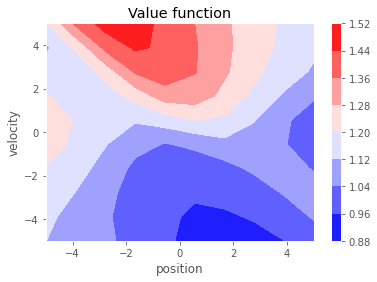

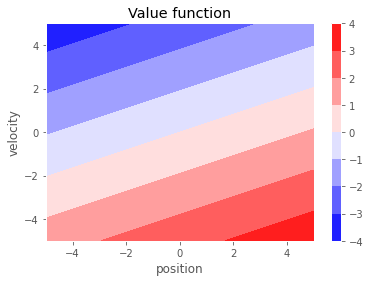

In [27]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zu = np.zeros((n, n))
zq = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        _, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        q_val = SAC.SQF.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        zv[i,j] = v_val
        zu[i,j] = u_val
        zq[i,j] = q_val

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

